In [1]:
import math
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

In [2]:
def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)


Stepsize = 0.03125
[[ 5.78734480e-03  5.38290538e-01 -1.04581036e+00]
 [ 1.69205095e-01  5.39857742e-01 -1.15982610e+00]
 [ 2.94922001e-01  5.76113405e-01 -1.24543695e+00]
 ...
 [-6.53372766e-01  8.54774623e-03  1.01434572e+00]
 [-4.75799878e-01 -1.66743206e-04  7.24119895e-01]
 [-3.53589790e-01 -3.61561007e-02  4.59567382e-01]]


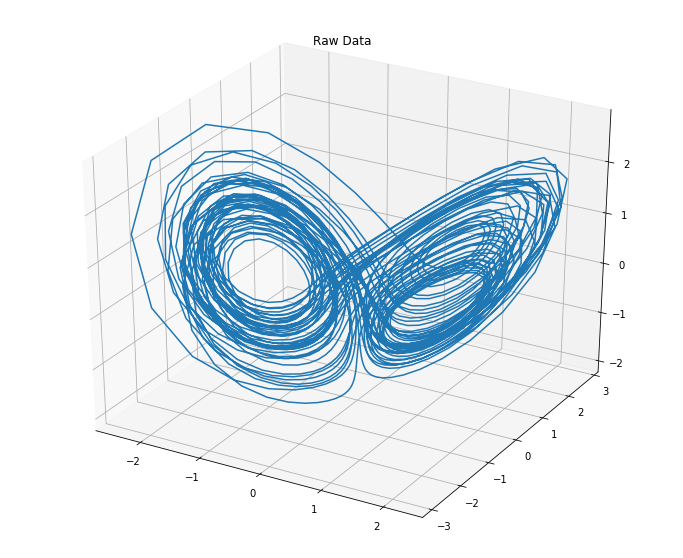

In [3]:
# Step 1
N = 2 ** 11
r = 3

end = 2**6
print("Stepsize = {st}".format(st=end/N))
t = np.linspace(0, end, num=N)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
ndrivers = 1
t0 = np.array([0,5,15])
# t0 = np.array([0.5])
# t0 = np.ones(r) * 0.3333 # np.zeros(dim)
# t0[0] += 0.1

# X = odeint(Lorenz96, t0,t)

# Lorenz

rho = lambda t : 22 + 12*np.sin(1.687/7*2*np.pi*t/N)# + 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1))  # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10.0 # + np.cos(1/2*2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((N,3))
states[0] = t0
for i in range(1, N ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
X = standardize(states)


"""
X = np.ones((N, r))
for i in range(N):
    for j in range(r):
        X[i,j] = i + j
"""
"""
X = np.array([[0,0,0,0],
              [0,0,0,0.5],
              [5,0,0,0],
              [10,0,0.5,0],
              [10,0,0,0]])
              """

print(X)

fig2 = plt.figure(2,figsize=(12,10))
if r == 1:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],"b") # states
elif r == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(X[:,0],X[:,1],X[:,2])
ax2.set_title("Raw Data")

plt.show()

In [4]:
# Step 2: chose parameters(how ??)
a = 0.5    # bias parameter, 0.5 matches intrinsic metric of system
k = 20  # number of neighbors
s = 10 # delay

In [5]:
# Step 3: Weighted Embedding

print("Embedding Dimensions: ",N-s, r*(s+1))
Xemb = np.zeros((N-s, r*(s+1)))
for e in range(s+1):
    Xemb[:,e*r:(e+1)*r] = np.exp(-k*e) * X[s-e:N-e,:]
    
print(Xemb, "Works as expected")

Embedding Dimensions:  2038 33
[[ 1.32492364e+00  1.50768114e+00 -4.66542432e-01 ...  8.00908637e-90
   7.44938405e-88 -1.44729332e-87]
 [ 1.42857969e+00  1.46059238e+00 -1.46622977e-01 ...  2.34162344e-88
   7.47107253e-88 -1.60507931e-87]
 [ 1.47149419e+00  1.30099374e+00  1.37864473e-01 ...  4.08141533e-88
   7.97281340e-88 -1.72355587e-87]
 ...
 [-6.53372766e-01  8.54774623e-03  1.01434572e+00 ... -1.39187624e-87
  -1.98292151e-87 -3.67850136e-88]
 [-4.75799878e-01 -1.66743206e-04  7.24119895e-01 ... -1.68956131e-87
  -2.35448605e-87 -4.03767411e-89]
 [-3.53589790e-01 -3.61561007e-02  4.59567382e-01 ... -2.01268215e-87
  -2.65320381e-87  4.90176382e-88]] Works as expected


In [6]:
# QR Decomposition, optional, used to reduce dimensionality


# Step 4: Generate Gaussian Random variables
m = Xemb.shape[1] # TODO: find out where m comes from

pi = np.random.normal(0,1,(m, r*(s+1)))

# Step 5: orthonormalize w/ QR

Q, R = la.qr(pi)
pihat = Q # is this a random orthonormal basis?

np.set_printoptions(suppress=True)

# Step 6: form compressed states
compressedStates = np.zeros(Xemb.shape) # corresponds to y_i hat

for i in range(Xemb.shape[0]):
    compressedStates[i,:] = (pihat @ Xemb[i,:,None]).T


In [7]:
# Step 7: find those neighbors

neighborIndices = np.zeros((Xemb.shape[0],k), dtype=int)

for i in range(Xemb.shape[0]):
    neighborIndices[i,:] = np.argsort(la.norm(Xemb[i,:] - Xemb,axis=1))[1:k+1]
    
print(neighborIndices)

[[  25   50  188 ...  693  364 1918]
 [  26  189   51 ... 1703   52    2]
 [  27  190   52 ...   26 1664 1683]
 ...
 [1818 1587 1566 ...  774 1346 1029]
 [1819 1567 1279 ... 1501 1347 2016]
 [1820 1143 1280 ...  776  752 1502]]


In [8]:
# Step 8: 

neighborMatrix = np.zeros((Xemb.shape[0],Xemb.shape[0]))
for point in range(neighborIndices.shape[0]):
    for neighborIndex in neighborIndices[point,:]:
        neighborMatrix[point, neighborIndex] = la.norm(compressedStates[neighborIndex] - compressedStates[point])
        
print(neighborMatrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.32900834 ... 0.         0.         0.        ]
 [0.         0.32900834 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [9]:
# Step 9: Normalization

epsilon = 2 * np.sum(neighborMatrix ** 2) / Xemb.shape[0]
print(epsilon)

2.4421395148742713


In [10]:
# Step 10: make sparse matrix
dhat = np.exp(-1 * np.power(neighborMatrix,2) / epsilon, where=neighborMatrix != 0)
print(dhat)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.95664353 ... 0.         0.         0.        ]
 [0.         0.95664353 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [11]:
# Step 11: Make symmetric Matrix

J = (dhat + dhat.T) / 2
print(J)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.95664353 ... 0.         0.         0.        ]
 [0.         0.95664353 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [12]:
# Step 12: form diagonal normalization matrix

P = np.diag(np.sum(J,axis=1))
print(P)

[[19.62300297  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         18.98337523  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         19.85630502 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 19.66744032  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         18.73191377
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  18.74161687]]


In [13]:
# Step 13: Normalize and form kernel matrix
# print(np.power(P, -a, where= P != 0))
K = np.power(P, -a, where= P != 0) @ J @ np.power(P,-a, where= P != 0)
print(K)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.04927359 ... 0.         0.         0.        ]
 [0.         0.04927359 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [14]:
# Step 14: 

Q = np.diag(np.sum(K,axis=1))
print(Q)


[[0.95613838 0.         0.         ... 0.         0.         0.        ]
 [0.         0.95096367 0.         ... 0.         0.         0.        ]
 [0.         0.         0.98956681 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.96009813 0.         0.        ]
 [0.         0.         0.         ... 0.         0.92997988 0.        ]
 [0.         0.         0.         ... 0.         0.         0.93062569]]


In [15]:
# Step 15: Form symmetric Matrix

""" NOTE: pronounced T-hat """ 
That = np.power(Q, -0.5, where= Q != 0) @ K @ np.power(Q,-0.5, where= Q != 0)
print(That)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.05079368 ... 0.         0.         0.        ]
 [0.         0.05079368 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [16]:
# Step 16: Eigenvectors and values

eigenValuesThat, eigenVectorsThat = la.eigh(That)

print(eigenValuesThat,"\n", eigenVectorsThat)

[-0.26504186 -0.26143781 -0.26061108 ...  0.993193    0.9968149
  1.        ] 
 [[-0.00011098  0.00093319 -0.00021145 ... -0.0138197   0.02633119
  -0.02169196]
 [-0.00025949 -0.0056432   0.0014109  ... -0.02199132  0.02687953
  -0.02163318]
 [-0.00018168  0.05029053 -0.01577481 ... -0.02542213  0.0266896
  -0.0220679 ]
 ...
 [ 0.00011135 -0.01836756  0.00797865 ... -0.01968091 -0.02268693
  -0.02173683]
 [-0.00010215  0.01300807 -0.00877486 ... -0.01369224 -0.01613812
  -0.02139317]
 [-0.00001843 -0.00567404  0.00400901 ... -0.00767019 -0.01058449
  -0.0214006 ]]


In [17]:
# Step 17: find T hat ^1/e eigenvalues

""" WARNING : DID ABSOLUTE VALUE TO DEAL WITH NEGATIVE EIGENVALS, COULD BE WRONG"""
eigenValuesThat = np.power(abs(eigenValuesThat), 1/(2*epsilon))
print(eigenValuesThat)

[0.76195665 0.75982377 0.75933121 ... 0.99860256 0.99934706 1.        ]


In [18]:
# Step 18: find eigenvec of T

eigenVectorsT = np.power(Q, -0.5,where= (Q!=0) ) @ eigenVectorsThat
print(eigenVectorsT)


[[-0.0001135   0.00095435 -0.00021624 ... -0.01413313  0.02692837
  -0.02218393]
 [-0.0002661  -0.00578686  0.00144682 ... -0.02255118  0.02756384
  -0.02218393]
 [-0.00018264  0.05055495 -0.01585775 ... -0.0255558   0.02682992
  -0.02218393]
 ...
 [ 0.00011364 -0.01874536  0.00814276 ... -0.02008572 -0.02315357
  -0.02218393]
 [-0.00010592  0.01348889 -0.0090992  ... -0.01419835 -0.01673463
  -0.02218393]
 [-0.0000191  -0.00588172  0.00415575 ... -0.00795094 -0.01097191
  -0.02218393]]


In [19]:
# Step 19: Compute Diffusion Map Variables

L = 6 # final dimension of reduced system
t = 5 # Number of diffusion steps (imagine raising the markov probability matrix to this power)
diffusionMap = (eigenValuesThat ** t) * eigenVectorsT
print(diffusionMap)

[[-0.00002915  0.0002417  -0.00005459 ... -0.01403465  0.02684057
  -0.02218393]
 [-0.00006834 -0.00146557  0.00036523 ... -0.02239405  0.02747397
  -0.02218393]
 [-0.00004691  0.01280348 -0.00400311 ... -0.02537773  0.02674245
  -0.02218393]
 ...
 [ 0.00002919 -0.00474743  0.00205555 ... -0.01994576 -0.02307808
  -0.02218393]
 [-0.0000272   0.00341618 -0.00229699 ... -0.01409942 -0.01668007
  -0.02218393]
 [-0.00000491 -0.0014896   0.00104907 ... -0.00789554 -0.01093614
  -0.02218393]]


In [20]:
# Step 20: Print Timescales

print(-1 / np.log(eigenValuesThat))

[   3.67828796    3.64074897    3.6321739  ...  715.09317001 1531.03237118
          -inf]


C:\Users\Kenneth\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# Step 21:

q = Q @ eigenVectorsT

In [22]:
# Step 22: 

print(X.shape)
print(q.shape)

numComponents = 100
DMDCComponents = np.zeros((numComponents, r))

for l in range(numComponents):
    for i in range(s+1, N):
        DMDCComponents[l] += X[i] * q[i-s, l]
print(DMDCComponents)

(2048, 3)
(2038, 2038)
[[ 0.01495253  0.00723884 -0.00874055]
 [-0.0086951  -0.00881365 -0.01256361]
 [-0.01659038 -0.00425775 -0.0070793 ]
 [ 0.00443306 -0.00704316 -0.00317732]
 [-0.01536203 -0.02736346 -0.03541966]
 [-0.01343573 -0.0143905   0.00407576]
 [-0.01608196 -0.03612526 -0.01537398]
 [-0.01332854  0.00637279  0.00656022]
 [ 0.00173614  0.01152258  0.0078091 ]
 [-0.00966756  0.02024627 -0.01153482]
 [-0.0645043   0.04794469  0.05824707]
 [ 0.06330834 -0.07078961 -0.04090678]
 [ 0.00315369  0.01625523  0.06414147]
 [-0.00573078 -0.01821693 -0.00577311]
 [ 0.02813843 -0.0073272  -0.01009817]
 [-0.00403536 -0.01585392 -0.01078422]
 [-0.00134886 -0.0177985   0.00259139]
 [-0.02601863 -0.02037792 -0.00327277]
 [-0.0057897  -0.05981174  0.00448736]
 [ 0.07462133  0.0256242  -0.02118009]
 [ 0.00286227  0.01691009 -0.00399445]
 [-0.01281087 -0.03719815 -0.0123675 ]
 [-0.00496901 -0.00931615  0.00572413]
 [-0.02775677 -0.0013921  -0.00779656]
 [-0.03067114 -0.04864834 -0.00368892]
 [

In [23]:
# Step 24: Make the video/ time series

DMDC = np.zeros((N,r))
L = np.array([0,1,2,3,4]) # << DMDC dimension under consideration

for i in range(N):
    for l in L:
        DMDC[i] = eigenValuesThat[l] * eigenVectorsT[i-s,l] * DMDCComponents[l]

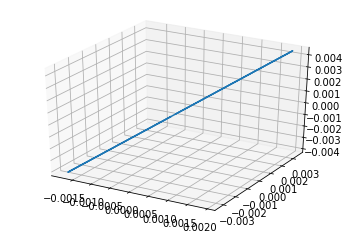

In [24]:
figDMDC = plt.figure()
axDM = figDMDC.add_subplot(projection ="3d")
# axDM.plot(np.fft.fft(diffusionMap[:,0]))
axDM.plot(DMDC[:,0],DMDC[:,1],DMDC[:,2])

plt.show()

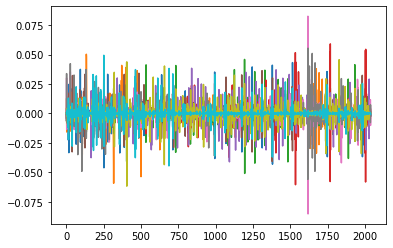

In [25]:
figDM, axDM = plt.subplots(1)
# axDM.plot(np.fft.fft(diffusionMap[:,0]))
axDM.plot(diffusionMap[:,:10])

plt.show()

In [26]:
# Step 21: form DMDC projections

q = Q @ diffusionMap
print(q.shape)

(2038, 2038)


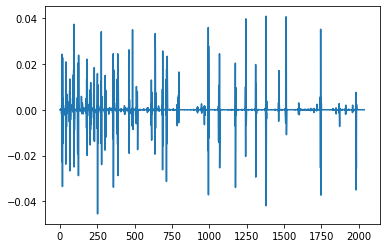

In [27]:
figDM, axDM = plt.subplots(1)
axDM.plot(q[:,0])

plt.show()